In [1]:
%matplotlib inline

import geopandas
import regionmask

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

from loca.data_catalog import load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

In [17]:
# create GeoDataFrame with all HUC2 elements
# huc 2 to 4, should WBDHU2.shp
dfs = []
hucs = list(range(1, 19))
for i in hucs:
    huc2_file = f'/glade/u/home/jhamman/projects/storylines/data/gis/WBD_{i:02d}_Shape/Shape/WBDHU2.shp' #TODO move file to repository
    gdf = geopandas.GeoDataFrame.from_file(huc2_file)
    dfs.append(gdf)
gdf = pd.concat(dfs)
gdf.index = hucs
gdf.tail()

,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC2,NAME,SHAPE_LENG,SHAPE_AREA,geometry
14,{55B52F2D-76B0-44EA-8BE7-B371E86617AC},None,None,None,None,20170417094157,2730145,72542421.23,293569.02,"AZ,CO,NM,UT,WY",14,Upper Colorado Region,44.6099267782046,30.6129409366829,POLYGON ((-110.0380510448476 43.45086882422225...
15,{5A8D623A-5571-4976-A98E-019A7A94E228},None,None,None,None,20161215130801,2730146,104858933.69,424349.42,"AZ,CA,MX,NM,NV,UT",15,Lower Colorado Region,59.1535619390035,41.4316896087394,"POLYGON ((-115.0786049495237 39.3005439327477,..."
16,{9567C98F-F09E-4C52-B2ED-C770AC69261B},None,None,None,None,20170201025311,2730147,90699698.29,367048.98,"CA,ID,NV,OR,UT,WY",16,Great Basin Region,68.0357227961479,38.5766697126077,POLYGON ((-111.6462335631847 42.85186860015205...
17,{31AE82B1-B1F0-4839-A09B-1836570B4D37},None,None,None,None,20170830145326,2730148,206707668.72,836517,"CA,CN,ID,MT,NV,OR,UT,WA,WY",17,Pacific Northwest Region,92.9588493772967,97.3040327044908,"POLYGON ((-118.981208715341 52.87765391479832,..."
18,{D924BD6E-507C-4E5B-A86C-DDDDE00752A5},None,None,None,None,20170201025214,2730149,107893988.58,436631.87,"CA,MX,NV,OR",18,California Region,61.1955899240585,44.5001629861605,(POLYGON ((-121.6369005216355 43.3402864254355...


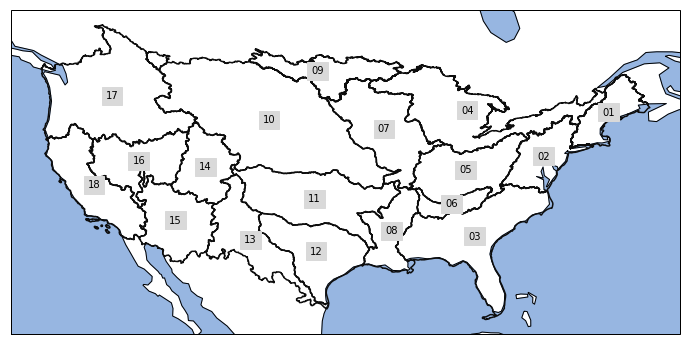

In [3]:
plt.figure(figsize=(12, 8))
# Create a Regions object for masking
huc_mask = regionmask.Regions_cls('USmask', range(len(gdf)), gdf.HUC2.values, list(map(str, hucs)), gdf.geometry.values)
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions_cls.html
huc_mask.plot(label='name')

plt.savefig('hucs.png', dpi=300)
# to save figure, do shift and two figure click... though it'd be nice to do this with plt.savefig(), though as it isn't plotted in matplotlib, unsure how to do this

In [4]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.217:40252 Dashboard: proxy/43053/status,Cluster Workers: 2 Cores: 4 Memory: 40.00 GB


In [5]:
read_cache = True
obs_data_maurer = {}
obs_data_livneh = {}
hist_data_all = {}
rcp4_data_all = {}
rcp8_data_all = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data_all[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp4_data_all[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data_all[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    obs_data_maurer = xr.open_mfdataset(os.path.join(cache_dir, 'monthly_hydro_obs.maurer.nc'),chunks={'time': 72})
    obs_data_livneh = xr.open_mfdataset(os.path.join(cache_dir, 'monthly_hydro_obs.livneh.nc'),chunks={'time': 72})

In [6]:
write_mask = False  #writing the mask takes about 20 mins for each key, value currently stashed bcsd (but easy to rewrite)

if write_mask:
    for key in ['loca']:
        monthly = hist_data_all[key].groupby('time.month').mean('time').load()  # TODO test (streamlined)
        huc_mask = regionmask.Regions_cls('USmask', range(len(gdf)), gdf.HUC2.values, list(map(str, hucs)), gdf.geometry.values)  # TODO test (streamlined)
        mask = huc_mask.mask(monthly, wrap_lon=False)
        display (mask)
        mask.plot()
        mask.load().to_netcdf(os.path.join(cache_dir, f'mask.{key}.nc'))

In [7]:
type(hist_data_all['loca'])

xarray.core.dataset.Dataset

In [8]:
#subset data so covers
hist_epoch = slice('1970-01-01', '1999-12-31')
futr_epoch = slice('2070-01-01', '2099-12-31')

obs_data = { "loca":obs_data_livneh.sel(time=hist_epoch), "bcsd":obs_data_maurer.sel(time=hist_epoch)}
hist_data = { "loca":hist_data_all['loca'].sel(time=hist_epoch), "bcsd":hist_data_all['bcsd'].sel(time=hist_epoch)}
rcp4_data = { "loca":rcp4_data_all['loca'].sel(time=futr_epoch), "bcsd":rcp4_data_all['bcsd'].sel(time=futr_epoch)}
rcp8_data = { "loca":rcp8_data_all['loca'].sel(time=futr_epoch), "bcsd":rcp8_data_all['bcsd'].sel(time=futr_epoch)}

In [9]:
#note: increased memory to run this on casper

hydro_var = 'total_runoff'

monthly = {}
data_by_huc_hist = {}
# data_by_huc_ens_mean = {}

for key in ['loca', 'bcsd']:
    monthly[key] = hist_data[key].groupby('time.month').mean('time').load()
    mask = xr.open_dataarray(os.path.join(cache_dir, f'mask.{key}.nc'))
    # Group data by huc
    data_by_huc_hist[key] = monthly[key].groupby(mask).mean('stacked_lat_lon')
    display(data_by_huc_hist[key])
#     data_by_huc_ens_mean[key] = data_by_huc[key][hydro_var].mean('gcm')
#     display(data_by_huc_ens_mean[key]) 

<xarray.Dataset>
Dimensions:       (gcm: 23, month: 12, region: 18)
Coordinates:
  * gcm           (gcm) <U14 'ACCESS1-0' 'CESM1-BGC' ... 'bcc-csm1-1' 'inmcm4'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) float64 0.0 1.0 2.0 3.0 4.0 ... 14.0 15.0 16.0 17.0
Data variables:
    ET            (region, month, gcm) float32 10.4842005 10.54254 ... 14.495675
    total_runoff  (region, month, gcm) float32 30.533447 29.655912 ... 21.706007
    SWE           (region, month, gcm) float32 100.36867 108.68096 ... 19.970484

<xarray.Dataset>
Dimensions:       (gcm: 23, month: 12, region: 18)
Coordinates:
  * gcm           (gcm) <U14 'ACCESS1-0' 'CESM1-BGC' ... 'bcc-csm1-1' 'inmcm4'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) float64 0.0 1.0 2.0 3.0 4.0 ... 14.0 15.0 16.0 17.0
Data variables:
    ET            (region, month, gcm) float32 18.28955 18.822092 ... 12.491267
    total_runoff  (region, month, gcm) float32 39.376987 40.965607 ... 25.65685
    SWE           (region, month, gcm) float32 47.994576 49.834103 ... 5.536129

In [10]:
# for observations
monthly = {}
data_by_huc_obs = {}
for key in ['loca', 'bcsd']:
    monthly[key] = obs_data[key].groupby('time.month').mean('time').load()
    mask = xr.open_dataarray(os.path.join(cache_dir, f'mask.{key}.nc'))
    data_by_huc_obs[key] = monthly[key].groupby(mask).mean('stacked_lat_lon')
    display(data_by_huc_obs[key])

<xarray.Dataset>
Dimensions:       (month: 12, region: 18)
Coordinates:
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) float64 0.0 1.0 2.0 3.0 4.0 ... 14.0 15.0 16.0 17.0
Data variables:
    ET            (region, month) float32 10.6566925 12.552088 ... 15.111202
    total_runoff  (region, month) float32 31.94435 28.367744 ... 20.886364
    SWE           (region, month) float32 101.4701 149.53241 ... 21.976925

<xarray.Dataset>
Dimensions:       (month: 12, region: 18)
Coordinates:
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) float64 0.0 1.0 2.0 3.0 4.0 ... 14.0 15.0 16.0 17.0
Data variables:
    ET            (region, month) float32 18.25132 18.984089 ... 11.989445
    total_runoff  (region, month) float32 38.73553 35.22101 ... 25.668928
    SWE           (region, month) float32 52.826176 96.0399 ... 10.287737

In [11]:
#  same as hist (above), but for future 
monthly = {}
data_by_huc_rcp4 = {}
for key in ['loca', 'bcsd']:
    monthly[key] = rcp4_data[key].groupby('time.month').mean('time').load()
    mask = xr.open_dataarray(os.path.join(cache_dir, f'mask.{key}.nc'))
    data_by_huc_rcp4[key] = monthly[key].groupby(mask).mean('stacked_lat_lon')  # Group data by huc

In [12]:
monthly = {}
data_by_huc_rcp8 = {}
for key in ['loca', 'bcsd']:
    monthly[key] = rcp8_data[key].groupby('time.month').mean('time').load()
    mask = xr.open_dataarray(os.path.join(cache_dir, f'mask.{key}.nc'))
    data_by_huc_rcp8[key] = monthly[key].groupby(mask).mean('stacked_lat_lon')     # Group data by huc

In [14]:
# i = 1
# region = i

# plt.plot(data_by_huc['bcsd']['total_runoff'].isel(region=i).mean('gcm'))
# plt.plot(data_by_huc['bcsd']['ET'].isel(region=i).mean('gcm'))
# plt.plot(data_by_huc['bcsd']['SWE'].isel(region=i).mean('gcm'))

# data_by_huc['bcsd']['total_runoff'].isel(region=0).mean('gcm').plot()
# display (lookup.index)

In [13]:
def joint_ax_lims(axes):
    low, high = axes[0].get_ylim()
    for ax in axes[1:]:
        low2, high2 = ax.get_ylim()
        low = min(low, low2)
        high = max(high, high2)
    for ax in axes:
        ax.set_ylim(low, high)
        

def add_month_lables(axes):
    for ax in axes:
        ax.set_xticks(list(range(0, 12)))
        ax.set_xticklabels(months)

reading hist
reading rcp8
reading diff
reading hist
reading rcp8
reading diff
reading hist
reading rcp8
reading diff
reading hist
reading rcp8
reading diff
reading hist
reading rcp8
reading diff
reading hist
reading rcp8
reading diff


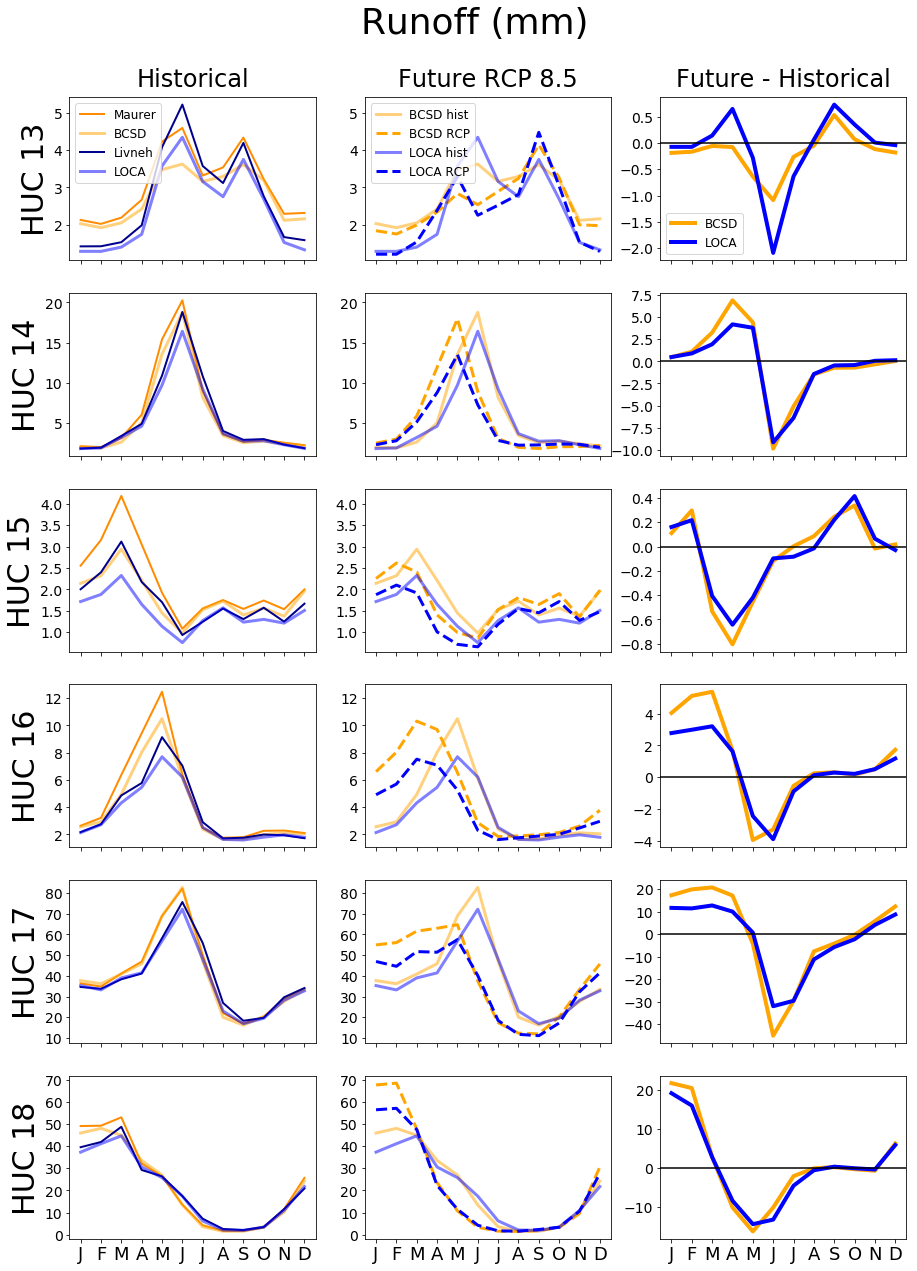

In [28]:
# HUC


# region = [2, 4, 8, 10, 13, 16];  #region + 1 = huc

# region = [0, 1, 2, 3, 4, 5];  #region + 1 = huc
# region = [6, 7, 8, 9, 10, 11];  #region + 1 = huc
region = [12, 13, 14, 15, 16, 17];  #region + 1 = huc

months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

fig, axes = plt.subplots(ncols=3, nrows=len(region), sharex=True, sharey=False, figsize=(15, len(region)*3.5), squeeze=True)


#TODO change units so right (e.g., maf)

lookup = gdf
staid = []

loca_color = "blue"
bcsd_color = "orange"

categoryx = ['hist', 'rcp8', 'diff']
names = {'hist': "Historical", 'rcp8': "Future RCP 8.5", 'diff': "Future - Historical"} 
maintitle = {'total_runoff': "Runoff (mm)", 'ET': "Evapotransipration (mm)", 'SWE': "SWE (mm)"}

for i, reg in enumerate(region):
    for j, scen in enumerate(categoryx):
        print(f'reading {scen}')
        plt.sca(axes[i, j])  #TODO fix "index out of bounds"

        if 'rcp4' in scen:
            bcsdlineh = plt.plot(data_by_huc_hist['bcsd'][hydro_var].isel(region=reg).mean('gcm'), color=bcsd_color, lw=3, alpha=0.5) 
            bcsdline = plt.plot(data_by_huc_rcp4['bcsd'][hydro_var].isel(region=reg).mean('gcm'), color=bcsd_color, lw=3, ls="--") 
            localineh = plt.plot(data_by_huc_hist['loca'][hydro_var].isel(region=reg).mean('gcm'), color=loca_color, lw=3, alpha=0.5)
            localine = plt.plot(data_by_huc_rcp4['loca'][hydro_var].isel(region=reg).mean('gcm'), color=loca_color, lw=3, ls="--")
            if i == 0:
                lineorder = ['bcsd hist', 'bcsd rcp', 'loca hist', 'loca rcp']
                plt.legend(lineorder, fontsize=12) 
            
        if 'rcp8' in scen:
            bcsdlineh = plt.plot(data_by_huc_hist['bcsd'][hydro_var].isel(region=reg).mean('gcm'), color=bcsd_color, lw=3, alpha=0.5) 
            bcsdline = plt.plot(data_by_huc_rcp8['bcsd'][hydro_var].isel(region=reg).mean('gcm'), color=bcsd_color, lw=3, ls="--") 
            localineh = plt.plot(data_by_huc_hist['loca'][hydro_var].isel(region=reg).mean('gcm'), color=loca_color, lw=3, alpha=0.5)
            localine = plt.plot(data_by_huc_rcp8['loca'][hydro_var].isel(region=reg).mean('gcm'), color=loca_color, lw=3, ls="--")
            if i == 0:
                lineorder = ['BCSD hist', 'BCSD RCP', 'LOCA hist', 'LOCA RCP']
                plt.legend(lineorder, fontsize=12) 
                
        if scen == 'diff':
            diffbcsd = data_by_huc_rcp8['bcsd'][hydro_var].isel(region=reg).mean('gcm') - data_by_huc_hist['bcsd'][hydro_var].isel(region=reg).mean('gcm') 
            plt.plot(diffbcsd, color = bcsd_color, lw=4)
            
            diffloca = data_by_huc_rcp8['loca'][hydro_var].isel(region=reg).mean('gcm') - data_by_huc_hist['loca'][hydro_var].isel(region=reg).mean('gcm')
            plt.plot(diffloca, color = loca_color, lw=4)
            plt.axhline(y=0, color='black')

            if i == 0:
                lineorder = ['BCSD', 'LOCA']
                plt.legend(lineorder, fontsize=12) 

        if scen == 'hist':  
            bcsdobs = plt.plot(data_by_huc_obs['bcsd'][hydro_var].isel(region=reg), color='darkorange', lw=2)
            bcsdhist = plt.plot(data_by_huc_hist['bcsd'][hydro_var].isel(region=reg).mean('gcm'), color=bcsd_color, lw=3, alpha=0.5)
            locaobs = plt.plot(data_by_huc_obs['loca'][hydro_var].isel(region=reg), color='darkblue', lw=2)  
            locahist = plt.plot(data_by_huc_hist['loca'][hydro_var].isel(region=reg).mean('gcm'), color=loca_color, lw=3, alpha=0.5) 
            
            if i == 0:
                lineorder = ['Maurer','BCSD', 'Livneh', 'LOCA']
                plt.legend(lineorder, fontsize=12) 
            
        if i == 0:
            title = names[scen]
            plt.title(title, fontsize=24, y=1.03)
            
        if j == 0:
            plt.ylabel(f'HUC {region[i] + 1}', fontsize=30)  #TODO write out huc number.  this works, BUT could be better.
        
        plt.xticks(size = 18)
        plt.yticks(size = 14)

            
    joint_ax_lims(axes[i, :2])

    
add_month_lables(axes[-1, :])


fig.suptitle(maintitle[hydro_var], fontsize=36, y=0.94)
            
        
plt.savefig(f'/glade/u/home/jvano/workdir/loca_figs/huc02.png', dpi=300, bbox_inches='tight')

In [22]:
title

'Future - Historical'

In [ ]:
hist_data['bcsd']['ET'].isel(time=0, gcm=1).plot()

In [ ]:
# loca = hist_data['loca'].isel()